In [13]:
# import necessary dependencies
import argparse
import os, sys
import time
from datetime import datetime 
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import numpy as np
import pandas as pd

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

In [2]:
# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

# parameters
RANDOM_SEED = 42

IMG_SIZE = 28
N_CLASSES = 10

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Device: {DEVICE}")

#############################################
# your code here
# construct dataset
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=True, download=True,
                 transform=torchvision.transforms.Compose([
                      torchvision.transforms.ToTensor()
                 ])),
  batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=False, download=True,
                 transform=torchvision.transforms.Compose([
                      torchvision.transforms.ToTensor()
                 ])),
  batch_size=VAL_BATCH_SIZE, shuffle=True)

Device: cuda


## Check Images

In [3]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    acc = correct_pred.float() / n
    return acc.item()

def plot_losses(train_losses, valid_losses, title_prefix):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))
    
    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title=f"{title_prefix}: Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

def train(train_loader, model, criterion, optimizer, device, teacher_model=None):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        if not teacher_model:
            loss = criterion(y_hat, y_true)
        else:
            with torch.no_grad():
                y_teacher = teacher_model(X)
            loss = criterion(y_hat, y_true, y_teacher)
            
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def training_loop(model, train_criterion, valid_criterion, optimizer, train_loader, valid_loader, 
                  epochs, device, print_every=1, teacher_model=None, prefix=""):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    acc_epochs = []
    train_accus = []
    valid_accus = []
    
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, train_criterion, optimizer, device, teacher_model)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, valid_criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            acc_epochs.append(epoch)
            train_acc = get_accuracy(model, train_loader, device=device)
            train_accus.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            valid_accus.append(valid_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses, prefix)
    res_acc = pd.DataFrame({
        "acc_epoch": acc_epochs,
        "train_accus": train_accus,
        "valid_accus": valid_accus
    })
    res_loss = pd.DataFrame({
        "loss_epoch": range(0, epochs),
        "train_losses": train_losses,
        "valid_losses": valid_losses,
    })
    str_time = datetime.now().strftime("%m_%d_%H%M")
    res_acc.to_csv(f"{prefix}_{str_time}_accus.csv" if prefix else f"{str_time}_accus.csv", index=False)
    res_loss.to_csv(f"{prefix}_{str_time}_losses.csv" if prefix else f"{str_time}_losses.csv", index=False)
    
    return model, optimizer, (train_losses, valid_losses)

## Models

In [4]:

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Conv2d(1, 6, 5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )
 

    def forward(self, x):
        logits = self.model(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

class StudentNet(nn.Module):

    def __init__(self, n_classes):
        super(StudentNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Conv2d(1, 1, 5, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(1, 2, 5, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(32, 10),
        )
 

    def forward(self, x):
        logits = self.model(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs


## Train Teacher Model

==========> Not find checkpoint, train
17:51:42 --- Epoch: 0	Train loss: 0.4584	Valid loss: 0.1419	Train accuracy: 95.25	Valid accuracy: 95.74
17:52:07 --- Epoch: 1	Train loss: 0.1219	Valid loss: 0.0817	Train accuracy: 97.20	Valid accuracy: 97.29
17:52:31 --- Epoch: 2	Train loss: 0.0850	Valid loss: 0.0699	Train accuracy: 97.77	Valid accuracy: 97.67
17:52:59 --- Epoch: 3	Train loss: 0.0672	Valid loss: 0.0470	Train accuracy: 98.44	Valid accuracy: 98.38
17:53:25 --- Epoch: 4	Train loss: 0.0558	Valid loss: 0.0461	Train accuracy: 98.54	Valid accuracy: 98.47
17:53:52 --- Epoch: 5	Train loss: 0.0476	Valid loss: 0.0458	Train accuracy: 98.69	Valid accuracy: 98.54
17:54:17 --- Epoch: 6	Train loss: 0.0415	Valid loss: 0.0398	Train accuracy: 99.01	Valid accuracy: 98.75
17:54:42 --- Epoch: 7	Train loss: 0.0354	Valid loss: 0.0383	Train accuracy: 99.14	Valid accuracy: 98.72
17:55:06 --- Epoch: 8	Train loss: 0.0325	Valid loss: 0.0339	Train accuracy: 99.24	Valid accuracy: 98.85
17:55:32 --- Epoch: 9	Tra

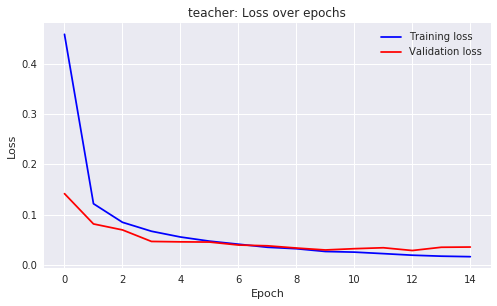

In [5]:
import os.path

LeNet5_CHECKPOINT = "LeNet5_trained_parameters.pt"
torch.manual_seed(RANDOM_SEED)

model_teacher = LeNet5(N_CLASSES).to(DEVICE)

if os.path.exists(LeNet5_CHECKPOINT):

  # load model Directly
  print("==========> Load Parameters")
  model_teacher.load_state_dict(torch.load(LeNet5_CHECKPOINT))
  
else:

  # If model not trained 
  print("==========> Not find checkpoint, train")

  LEARNING_RATE = 0.001
  N_EPOCHS = 15
  optimizer = torch.optim.Adam(model_teacher.parameters(), lr=LEARNING_RATE)
  train_criterion = nn.CrossEntropyLoss()
  valid_criterion = nn.CrossEntropyLoss()

  model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                              N_EPOCHS, DEVICE, prefix="teacher")

  # Save model 
  torch.save(model_teacher.state_dict(), LeNet5_CHECKPOINT)
  


# Train student model base on teacher's soft label

## Small Model : *Student Model*

# Different Temprature 

=======> Temperature: 2


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


18:28:16 --- Epoch: 0	Train loss: 0.4946	Valid loss: 0.5750	Train accuracy: 84.24	Valid accuracy: 85.28
18:28:40 --- Epoch: 1	Train loss: 0.2008	Valid loss: 0.5043	Train accuracy: 86.54	Valid accuracy: 87.39
18:29:04 --- Epoch: 2	Train loss: 0.1795	Valid loss: 0.4763	Train accuracy: 87.43	Valid accuracy: 88.24
18:29:28 --- Epoch: 3	Train loss: 0.1690	Valid loss: 0.4451	Train accuracy: 88.23	Valid accuracy: 88.90
18:29:52 --- Epoch: 4	Train loss: 0.1604	Valid loss: 0.4290	Train accuracy: 88.73	Valid accuracy: 89.66
18:30:16 --- Epoch: 5	Train loss: 0.1524	Valid loss: 0.4019	Train accuracy: 89.24	Valid accuracy: 90.19
18:30:39 --- Epoch: 6	Train loss: 0.1448	Valid loss: 0.3862	Train accuracy: 89.64	Valid accuracy: 90.45
18:31:05 --- Epoch: 7	Train loss: 0.1378	Valid loss: 0.3707	Train accuracy: 90.12	Valid accuracy: 90.78
18:31:29 --- Epoch: 8	Train loss: 0.1317	Valid loss: 0.3505	Train accuracy: 90.40	Valid accuracy: 90.86
18:31:53 --- Epoch: 9	Train loss: 0.1258	Valid loss: 0.3452	Trai

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


18:34:20 --- Epoch: 0	Train loss: 1.6333	Valid loss: 0.7140	Train accuracy: 82.73	Valid accuracy: 84.25
18:34:43 --- Epoch: 1	Train loss: 0.7727	Valid loss: 0.5820	Train accuracy: 85.62	Valid accuracy: 86.44
18:35:08 --- Epoch: 2	Train loss: 0.6605	Valid loss: 0.4928	Train accuracy: 87.86	Valid accuracy: 88.70
18:35:32 --- Epoch: 3	Train loss: 0.5976	Valid loss: 0.4458	Train accuracy: 88.75	Valid accuracy: 89.49
18:35:58 --- Epoch: 4	Train loss: 0.5499	Valid loss: 0.4002	Train accuracy: 89.82	Valid accuracy: 90.30
18:36:21 --- Epoch: 5	Train loss: 0.5094	Valid loss: 0.3615	Train accuracy: 90.81	Valid accuracy: 91.16
18:36:45 --- Epoch: 6	Train loss: 0.4781	Valid loss: 0.3384	Train accuracy: 91.31	Valid accuracy: 91.69
18:37:09 --- Epoch: 7	Train loss: 0.4541	Valid loss: 0.3124	Train accuracy: 91.91	Valid accuracy: 92.22
18:37:34 --- Epoch: 8	Train loss: 0.4356	Valid loss: 0.3036	Train accuracy: 92.02	Valid accuracy: 92.32
18:37:58 --- Epoch: 9	Train loss: 0.4209	Valid loss: 0.2899	Trai

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


18:40:21 --- Epoch: 0	Train loss: 4.4139	Valid loss: 2.3424	Train accuracy: 10.22	Valid accuracy: 10.10
18:40:45 --- Epoch: 1	Train loss: 4.3922	Valid loss: 2.4111	Train accuracy: 10.22	Valid accuracy: 10.10
18:41:09 --- Epoch: 2	Train loss: 4.3805	Valid loss: 2.4813	Train accuracy: 10.22	Valid accuracy: 10.10
18:41:33 --- Epoch: 3	Train loss: 4.3740	Valid loss: 2.5417	Train accuracy: 10.22	Valid accuracy: 10.10
18:41:57 --- Epoch: 4	Train loss: 2.8444	Valid loss: 0.7679	Train accuracy: 81.88	Valid accuracy: 82.43
18:42:22 --- Epoch: 5	Train loss: 1.1149	Valid loss: 0.5457	Train accuracy: 86.41	Valid accuracy: 87.38
18:42:47 --- Epoch: 6	Train loss: 0.9624	Valid loss: 0.4562	Train accuracy: 87.92	Valid accuracy: 88.80
18:43:10 --- Epoch: 7	Train loss: 0.8743	Valid loss: 0.4179	Train accuracy: 88.51	Valid accuracy: 89.55
18:43:35 --- Epoch: 8	Train loss: 0.8101	Valid loss: 0.3571	Train accuracy: 90.02	Valid accuracy: 90.69
18:44:00 --- Epoch: 9	Train loss: 0.7599	Valid loss: 0.3326	Trai

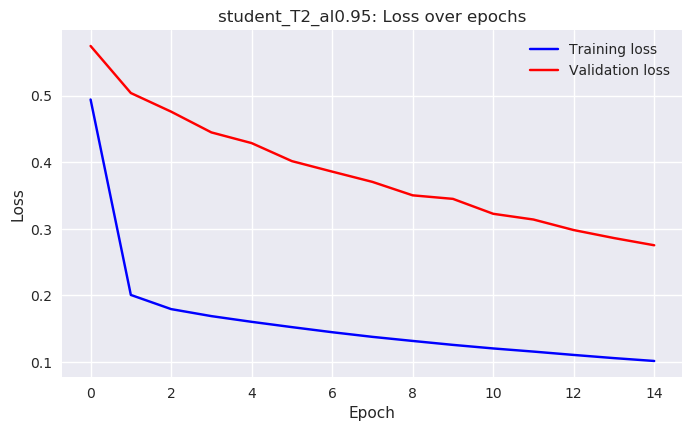

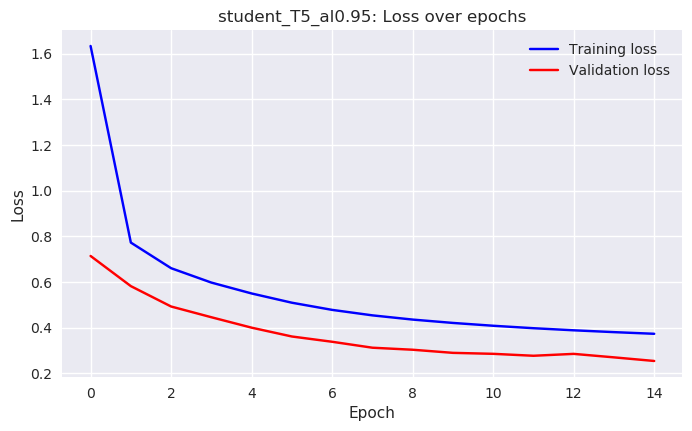

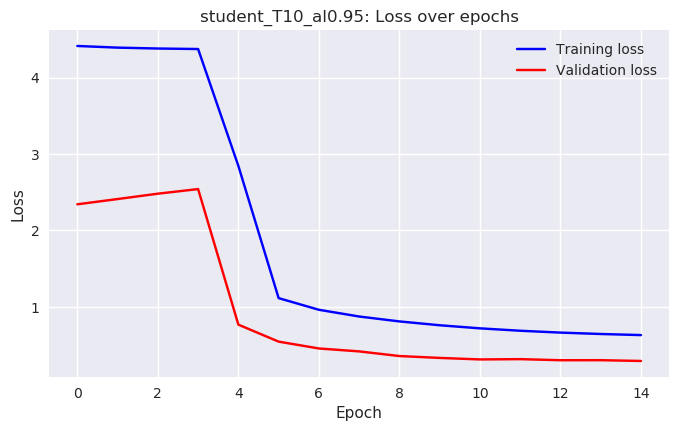

In [12]:

class SoftCrossEntropyLoss(nn.Module):

  def __init__(self, temperature, alpha):
    super(SoftCrossEntropyLoss, self).__init__()
    self.T = temperature
    self.alpha = alpha

  def forward(self, student_pred, label, teacher_pred):
    return nn.KLDivLoss()(F.log_softmax(student_pred/self.T,dim=1), F.softmax(teacher_pred[0]/self.T, dim=1)) * self.alpha * self.T * self.T + \
    F.cross_entropy(student_pred, label) * (1-self.alpha)


T = [2, 5, 10]

# Train 
LEARNING_RATE = 0.001
N_EPOCHS = 15
alpha = 0.95

for t in T:

  print(f"=======> Temperature: {t}")
  model_s = StudentNet(N_CLASSES).to(DEVICE)
  optimizer = torch.optim.Adam(model_s.parameters(), lr=LEARNING_RATE)

  valid_criterion = nn.CrossEntropyLoss()
  train_criterion = SoftCrossEntropyLoss(t, alpha)

  model_s, optimizer, _ = training_loop(model_s, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                        N_EPOCHS, DEVICE, teacher_model = model_teacher, prefix=f"student_T{t}_al{alpha}")

In [10]:
!pip install pthflops
!pip install torchsummary

In [11]:
from pthflops import count_ops
from torchsummary import summary

student_model = StudentNet(N_CLASSES).to(DEVICE)
 
summary(student_model, (1, 28, 28))
count_ops(student_model.model, torch.rand(1,1,28,28).to(DEVICE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 26, 26]              26
              ReLU-2            [-1, 1, 26, 26]               0
         AvgPool2d-3            [-1, 1, 13, 13]               0
            Conv2d-4              [-1, 2, 9, 9]              52
              ReLU-5              [-1, 2, 9, 9]               0
         AvgPool2d-6              [-1, 2, 4, 4]               0
           Flatten-7                   [-1, 32]               0
            Linear-8                   [-1, 10]             330
Total params: 408
Trainable params: 408
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.02
----------------------------------------------------------------
FX is unsupported on your pytorch version, falling

/opt/conda/lib/python3.6/site-packages/pthflops/__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)


(24426,
 [['Sequential/Conv2d[0]/onnx::Conv', 17576],
  ['Sequential/ReLU[1]/onnx::Relu', 1352],
  ['Sequential/AvgPool2d[2]/onnx::AveragePool', 676],
  ['Sequential/Conv2d[3]/onnx::Conv', 4050],
  ['Sequential/ReLU[4]/onnx::Relu', 324],
  ['Sequential/AvgPool2d[5]/onnx::AveragePool', 128],
  ['Sequential/Linear[7]/onnx::Gemm', 320]])